In [1]:
import numpy as np
import librosa
import csv
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Load the audio file
audio_file = "chopin.wav"
y, sr = librosa.load(audio_file, sr=None)

# Define chunk size and overlap
chunk_size = 8192  # Increase chunk size for higher resolution
overlap = 4096  # Ensure overlap is smaller than chunk size

# Calculate number of chunks
num_chunks = (len(y) - overlap) // (chunk_size - overlap)

# Create a list to store data
data = []

# MIDI note number for A4 (440 Hz)
A4_note_number = 69

# Function to convert MIDI note number to frequency
def note_number_to_frequency(note_number):
    return 440 * 2 ** ((note_number - 69) / 12)

In [3]:
# Loop over chunks
for i in range(num_chunks):
    
    start = i * (chunk_size - overlap)
    end = start + chunk_size
    chunk = y[start:end]

    # Perform FFT on the chunk
    fft_result = np.fft.fft(chunk)

    # Calculate frequencies corresponding to FFT result
    frequencies = np.fft.fftfreq(len(chunk), d=1/sr)

    # Keep only positive frequencies
    positive_frequencies = frequencies[:len(chunk)//2]
    magnitude_spectrum = np.abs(fft_result)[:len(chunk)//2]

    # Limit frequencies to 4,000 Hz
    max_frequency_index = np.argmax(positive_frequencies >= 4000)
    positive_frequencies = positive_frequencies[:max_frequency_index]
    magnitude_spectrum = magnitude_spectrum[:max_frequency_index]

    # Find peaks above a certain threshold
    peaks, _ = find_peaks(magnitude_spectrum, height=40)

    # Create a dictionary to store amplitude values for each note
    note_amplitudes = {}
    for frequency in positive_frequencies:
        if frequency > 0:  # Check if frequency is positive
            try:
                note_number = round(12 * np.log2(frequency / note_number_to_frequency(A4_note_number)) + A4_note_number)
                if note_number >= 0 and note_number <= 127:
                    note_name = librosa.core.midi_to_note(note_number)
                    note_amplitudes[note_name] = 0
            except (ValueError, ZeroDivisionError, OverflowError):
                pass  # Skip frequencies resulting in errors

    # Fill dictionary with amplitude values for peaks
    for peak in peaks:
        frequency = positive_frequencies[peak]
        if frequency > 0:  # Check if frequency is positive
            try:
                note_number = round(12 * np.log2(frequency / note_number_to_frequency(A4_note_number)) + A4_note_number)
                if note_number >= 0 and note_number <= 127:
                    note_name = librosa.core.midi_to_note(note_number)
                    amplitude_value = magnitude_spectrum[peak]
                    note_amplitudes[note_name] = round(amplitude_value, 2)  # Round amplitude to two decimal points
            except (ValueError, ZeroDivisionError, OverflowError):
                pass  # Skip frequencies resulting in errors

    # Append note amplitudes to data list
    data.append(list(note_amplitudes.values()))


In [4]:
# Sort note names by their MIDI note numbers
sorted_note_names = sorted(note_amplitudes.keys(), key=lambda x: librosa.core.note_to_midi(x))
sorted_note_numbers = [librosa.core.note_to_midi(note) for note in sorted_note_names]

# Combine note names and numbers
combined_headers = [f"{note} ({number})" for note, number in zip(sorted_note_names, sorted_note_numbers)]

# Write data to CSV file
csv_file = "output.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write combined header
    writer.writerow(sorted_note_names)
    
    # Write data rows
    writer.writerows(data)

In [5]:
# Read the CSV file
df = pd.read_csv("output.csv")

# Drop columns with all zeros
df = df.loc[:, (df != 0).any(axis=0)]

# Write the modified DataFrame back to CSV
df.to_csv("processed_output.csv", index=False)

# Print number of rows and columns
num_rows, num_columns = df.shape
print(f"\nNumber of Frames: {num_rows}")
print(f"Number of Notes Present: {num_columns}")



Number of Frames: 269
Number of Notes Present: 47


In [6]:
# Read the CSV file
df = pd.read_csv("processed_output.csv", header=0)

# Transpose
df = df.T

In [7]:
# # Plot the data
# plt.figure(figsize=(40, 80))
# plt.imshow(df.values, aspect='equal', cmap='binary', origin='lower', interpolation='none')
# plt.xlabel("Rows")
# plt.ylabel("Columns")
# plt.title("Processed Output")

# # Change edge color based on cell value
# for i in range(len(df.index)):
#     for j in range(len(df.columns)):
#         cell_value = df.iat[i, j]  # Get cell value
        
#         if cell_value == 0:  # If cell is absent
#             edge_color = 'red'
#             face_color = 'none'
#         else:  # If cell is present
#             edge_color = 'black'
#             face_color = (0, 0, 1, 0.5)  # Lighter blue with 50% opacity

#         plt.gca().add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=2, edgecolor=edge_color, facecolor=face_color))

# plt.show()

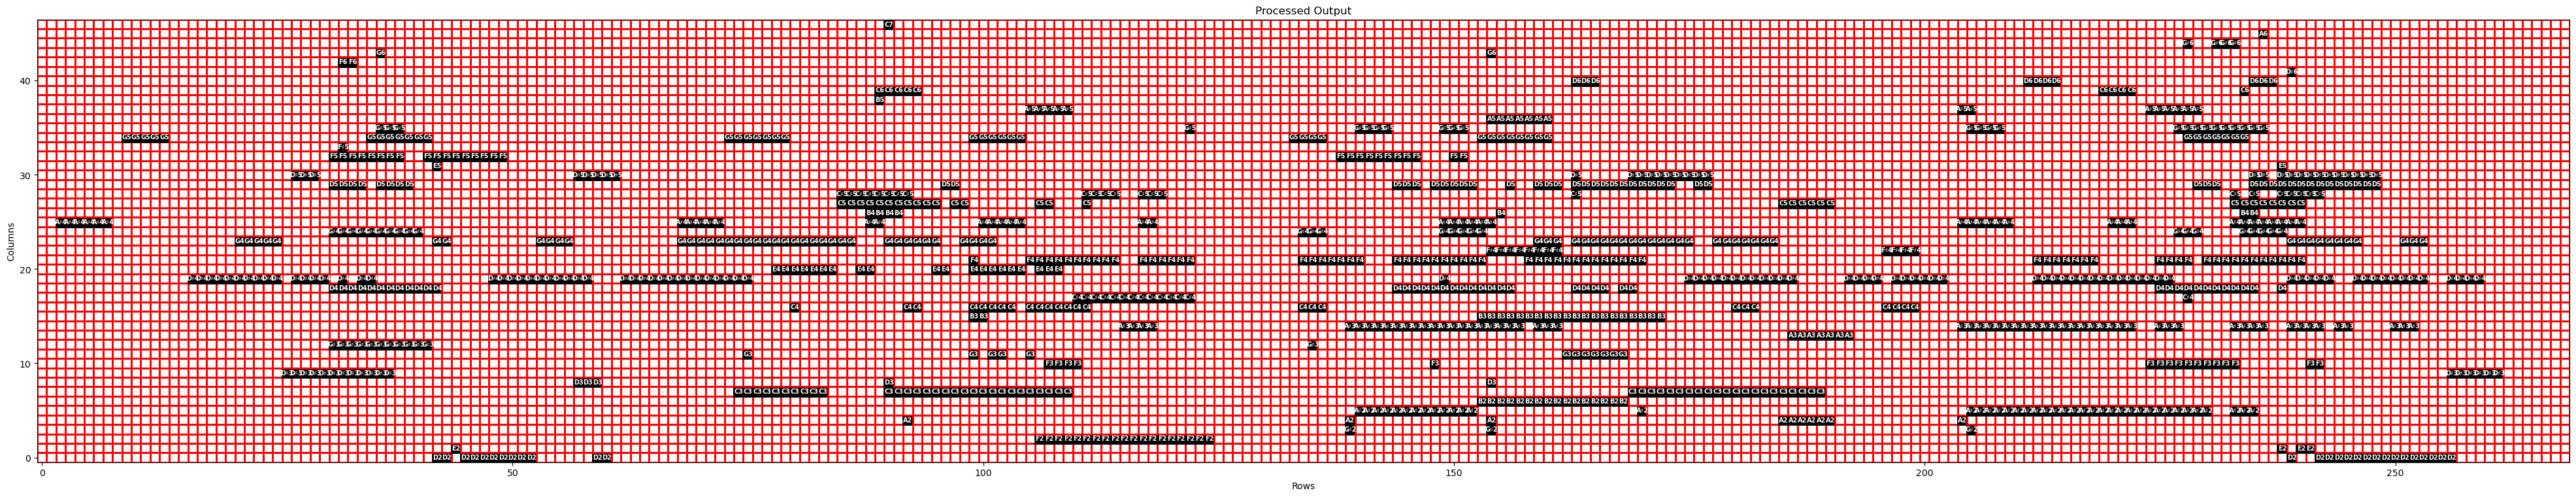

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Read the CSV file with the first row as column names
df = pd.read_csv("processed_output.csv", header=0)

# Convert column names to strings
df.columns = df.columns.astype(str)

# Plot the data
plt.figure(figsize=(50, 100))
plt.imshow(df.values.T, aspect='equal', cmap='binary', origin='lower', interpolation='none')  # Transpose the values
plt.ylabel("Columns")  # Reverse the labels for rows and columns
plt.xlabel("Rows")
plt.title("Processed Output")

# Change edge color based on cell value
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        cell_value = df.iat[i, j]  # Get cell value
        
        if cell_value == 0:  # If cell is absent
            edge_color = 'red'
            face_color = 'none'
        else:  # If cell is present
            edge_color = 'black'
            face_color = (0, 0, 0, 1)  # Lighter blue with 50% opacity
            
            # Add column header as annotation
            plt.annotate(df.columns[j], xy=(i, j), xytext=(0, 0), textcoords='offset points', ha='center', va='center', fontsize=7, color='white', fontweight='bold')

        plt.gca().add_patch(Rectangle((i - 0.5, j - 0.5), 1, 1, linewidth=2, edgecolor=edge_color, facecolor=face_color))

plt.show()
